In [11]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
from tqdm.auto import tqdm

import os
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
import matplotlib.pyplot as plt

# Data Augmentation

In [9]:

# Ruta a la carpeta principal donde se encuentran las 2 clases
# Ejemplo: dataPractica/caltech101/101_ObjectCategories
ruta_base = '../dataPractica/caltech101/101_ObjectCategories'

# Lista de clases de interés
clases_de_interes = ['buddha', 'dalmatian']

# Definir cuántas versiones nuevas quieres crear por cada imagen original.
# Ajusta este número según la cantidad de imágenes finales que quieras.
# Por ejemplo:
# - 2 => triplicas (aprox.) tu dataset
# - 3 => cuadruplicas, etc.
num_nuevas_por_imagen = 2

# Definimos las transformaciones de data augmentation que generan imágenes realistas 
# para buddha y dalmatian. Evitamos volteos verticales o rotaciones extremas.
transformaciones = transforms.Compose([
    # 1) Ajuste del tamaño a 256x256
    transforms.Resize((256, 256)),

    # 2) Recorte aleatorio para 224x224, simulando diferentes encuadres/zoom
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),       # rango de escalado
        ratio=(0.9, 1.1)        # rango de aspecto (ancho x alto)
    ),

    # 3) Rotación aleatoria moderada (±15 grados)
    transforms.RandomRotation(degrees=15),

    # 4) Flip horizontal aleatorio (probabilidad 0.5)
    transforms.RandomHorizontalFlip(p=1),

    # 5) Ajustes de color para simular distintas condiciones de iluminación
    transforms.ColorJitter(
        brightness=0.2, 
        contrast=0.2, 
        saturation=0.2, 
        hue=0.05
    ),

    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0,), (1,))  # Normalización
])

num_buddhas_originales = 85
num_dalmatians_originales = 67

# ---- CREACIÓN DE NUEVAS IMÁGENES ----
for clase in clases_de_interes:
    # Carpeta de origen (donde están las imágenes originales)
    carpeta_origen = os.path.join(ruta_base, clase).replace('\\', '/')

    carpeta_destino = carpeta_origen
    os.makedirs(carpeta_destino, exist_ok=True)

    if clase == 'buddha':
        indice = num_buddhas_originales
    else:
        indice = num_dalmatians_originales

    # Listar las imágenes originales
    imagenes = [
        f for f in os.listdir(carpeta_origen)
        if os.path.isfile(os.path.join(carpeta_origen, f)) 
           and f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ][:indice]

    print(f"\nClase: {clase}")
    print(f"  Imágenes originales: {len(imagenes)}")

    
    indice += 1
    # Generar nuevas imágenes
    contador_nuevas = 0
    for nombre_imagen in imagenes:
        ruta_imagen = os.path.join(carpeta_origen, nombre_imagen)

        # Abrir la imagen original en modo RGB
        imagen_original = Image.open(ruta_imagen).convert('RGB')

        # Crear 'num_nuevas_por_imagen' transformaciones diferentes
        for i in range(num_nuevas_por_imagen):
            # Aplicar transformaciones
            imagen_trans = transformaciones(imagen_original)

            # En caso de que la transformación devuelva un tensor, convertimos a PIL
            if isinstance(imagen_trans, torch.Tensor):
                imagen_trans = torchvision.transforms.ToPILImage()(imagen_trans)

            # Definir el nombre para la imagen aumentada
            nombre_sin_ext, ext = os.path.splitext(nombre_imagen)
            num_ceros = max(0, 4 - len(str(indice)))
            indice_formateado = f"{'0' * num_ceros}{indice}"
            nuevo_nombre = f"image_{indice_formateado}{ext}"

            # Guardar la imagen nueva en la carpeta destino
            ruta_salida = os.path.join(carpeta_destino, nuevo_nombre)
            imagen_trans.save(ruta_salida)

            indice += 1

    print(f"  Imágenes aumentadas generadas: {contador_nuevas}")
    print(f"  Guardadas en: {carpeta_destino}")
    



Clase: buddha
  Imágenes originales: 85
  Imágenes aumentadas generadas: 0
  Guardadas en: ../dataPractica/caltech101/101_ObjectCategories/buddha

Clase: dalmatian
  Imágenes originales: 67
  Imágenes aumentadas generadas: 0
  Guardadas en: ../dataPractica/caltech101/101_ObjectCategories/dalmatian


# Load Dataset

In [5]:
EPOCHS = 5
BATCH_SIZE = 4

Tamaño del lote de imágenes: torch.Size([4, 3, 224, 224])
Etiquetas: tensor([1, 0, 0, 1])


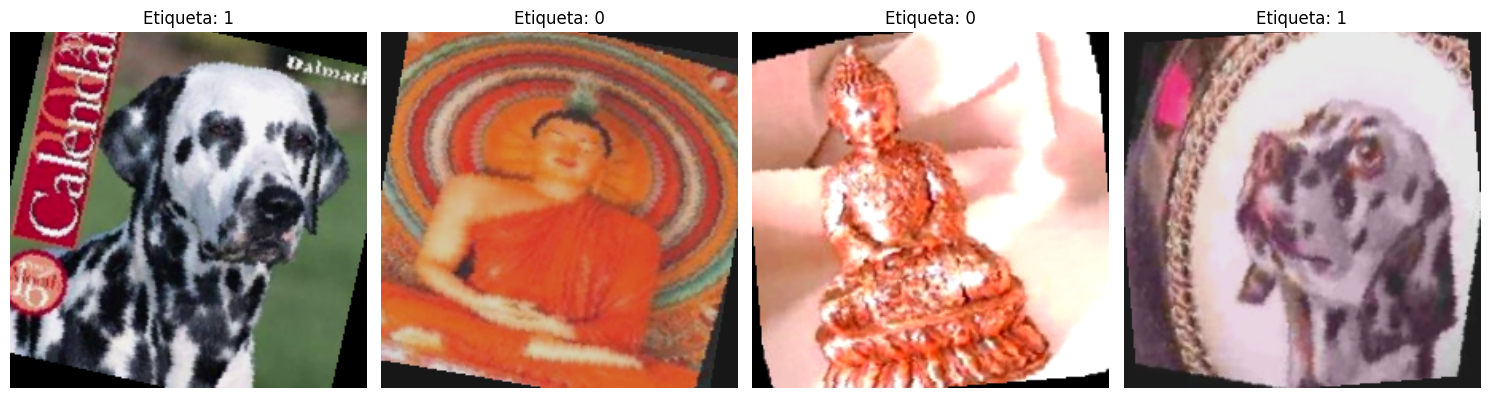

In [ ]:
# Cargar el dataset con ImageFolder

dataset = datasets.ImageFolder(
    root=ruta_base,
    transform=transformaciones
)

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Crear los data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Probar el dataset cargando un lote
for images, labels in train_loader:
    print(f"Tamaño del lote de imágenes: {images.shape}")
    print(f"Etiquetas: {labels}")
    
    # Calcular el número de filas necesarias
    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols  # Redondear hacia arriba

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

    for i, (img, ax) in enumerate(zip(images, axes)):
        img = transforms.ToPILImage()(img)  # Convertir el tensor a imagen PIL
        ax.imshow(img, interpolation='bilinear')  # Mejor interpolación
        ax.set_title(f"Etiqueta: {labels[i].item()}")
        ax.axis("off")

    # Ocultar los ejes sobrantes si hay menos imágenes que espacios
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()  # Ajustar los espacios en el plot
    plt.show()
    break  # Salir después de mostrar un lote

# Clasificación de imágenes

## ALexNet

In [34]:
# Cargar el modelo AlexNet preentrenado
alexNet = models.alexnet(pretrained=True)
print(alexNet)

# Congelar todos los parámetros para el Fine Tuning
for param in alexNet.parameters():
    param.requires_grad = False

alexNet.classifier[6] = nn.Linear(alexNet.classifier[6].in_features, len(clases_de_interes))

# Definir el criterio (función de pérdida) y el optimizador
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(alexNet.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = alexNet.to(device)

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

c:\Users\alber\miniconda3\envs\ia_2024\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alber\miniconda3\envs\ia_2024\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0
    
    i_batch = 1
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"):
        alexNet.train()  # Posam el model a mode entranament.

        optimizer.zero_grad()

        # 1. PREDICCIÓ

        y_pred = alexNet(x.to(device))

        # 2. CALCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        loss = loss_fn(y_pred, y.to(device))

        #3. GRADIENT
        alexNet.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIO
        with torch.no_grad():
            optimizer.step()

        # 5. EVALUAM EL MODEL
        alexNet.eval()  # Mode avaluació de la xarxa

        y_pred = alexNet(x.to(device))
        batch_loss += (loss_fn(y_pred, y.to(device)).detach().cpu())

        y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
        batch_acc += accuracy_score(y.cpu().numpy(), y_pred_class)


    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0

    alexNet.eval()
    for i_batch, (x, y) in enumerate(test_loader):

        y_pred = alexNet(x.to(device))
        batch_test_loss += (loss_fn(y_pred, y.to(device)).detach().cpu())
        y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
        acc = accuracy_score(y.cpu().numpy(), y_pred_class)
        batch_test_acc += acc

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc.append(batch_test_acc / (i_batch + 1))

Batches (Època 1): 91it [00:00, 108.95it/s]/s]
Batches (Època 2): 91it [00:00, 127.17it/s]  1.08it/s]
Batches (Època 3): 91it [00:00, 133.50it/s]  1.16it/s]
Batches (Època 4): 91it [00:00, 137.82it/s]  1.22it/s]
Batches (Època 5): 91it [00:00, 134.80it/s]  1.27it/s]
Èpoques: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


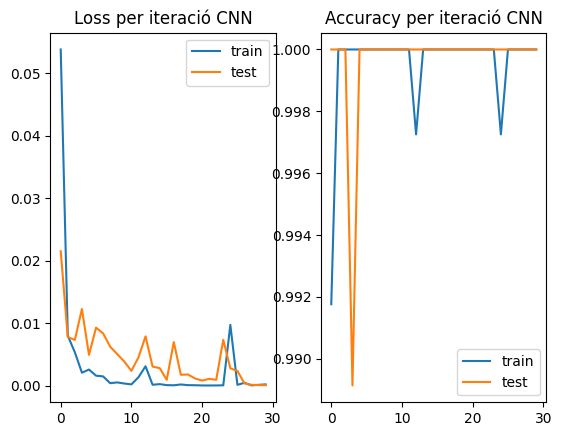

In [32]:
plt.subplot(1,2,1)
plt.title("Loss per iteració CNN")
plt.plot([loss.cpu().item() for loss in running_loss], label="train")
plt.plot([loss.cpu().item() for loss in running_test_loss], label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc, label="test")
plt.legend()
plt.show()

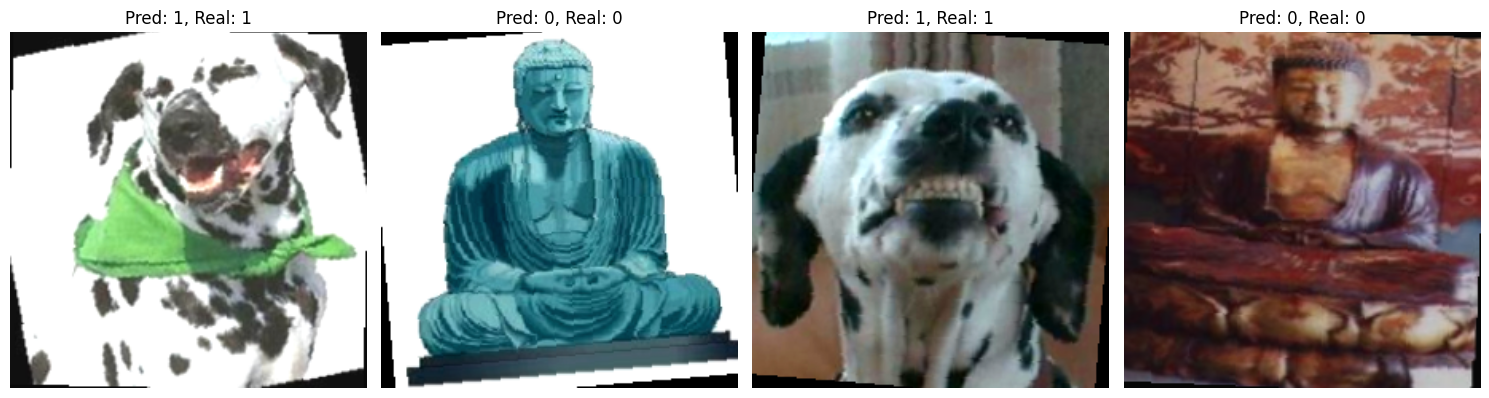

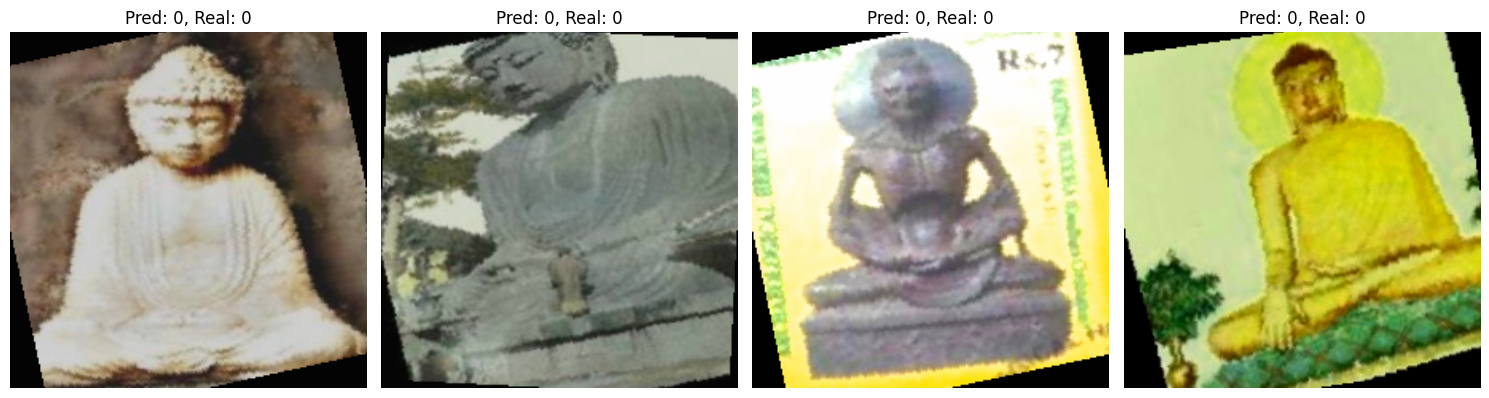

In [33]:
# Iterar sobre 2 batches de test
num_batches_to_display = 2
batches_displayed = 0

for images, labels in test_loader:
    if batches_displayed >= num_batches_to_display:
        break

    # Predicción
    y_pred = alexNet(images.to(device))
    y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()

    # Calcular el número de filas necesarias
    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols  # Redondear hacia arriba

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

    for i, (img, ax) in enumerate(zip(images, axes)):
        img = transforms.ToPILImage()(img)  # Convertir el tensor a imagen PIL
        ax.imshow(img, interpolation='bilinear')  # Mejor interpolación
        ax.set_title(f"Pred: {y_pred_class[i]}, Real: {labels[i].item()}")
        ax.axis("off")

    # Ocultar los ejes sobrantes si hay menos imágenes que espacios
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()  # Ajustar los espacios en el plot
    plt.show()

    batches_displayed += 1